## Use feature engineering & FLAML to solve [Titanic Kaggle Competition](https://www.kaggle.com/c/titanic/)

### Install FLAML

In [1]:
!pip3 install install flaml

### Load datasets

In [2]:
import pandas as pd

train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Inspect the number of missing values:

In [4]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Feature engineering and selection

It's commonly known that ```Pclass``` and ```Sex``` are the most prominent survival factors:

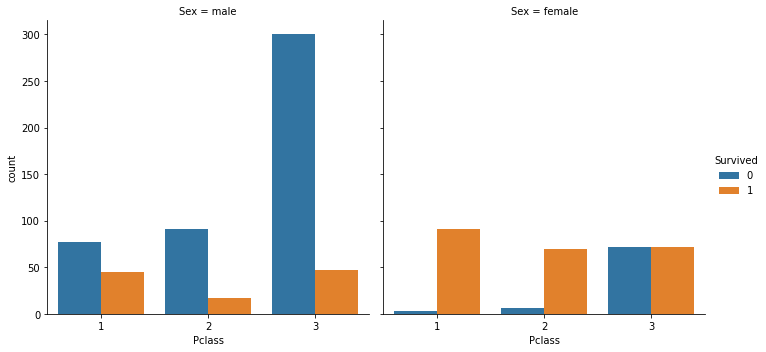

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.catplot(kind='count', data=train, x='Pclass', col='Sex', hue='Survived')
plt.show()

Add a feature ```3rd_class``` since these passengers were far more likely to die:

In [6]:
f = lambda n: n == 3

train['3rd_class'] = train.Pclass.apply(f)
test['3rd_class'] = test.Pclass.apply(f)

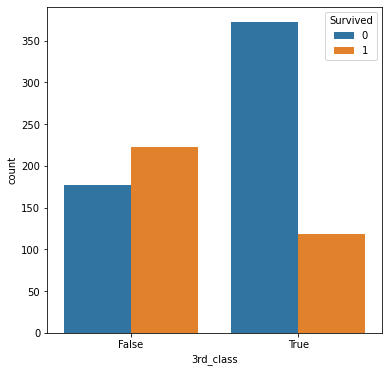

In [7]:
plt.figure(figsize=(6, 6))
sns.countplot(data=train, x='3rd_class', hue='Survived')
plt.show()

Passengers paid more (```Fare```) were more likely to survive (outliers are hidden in the graph):

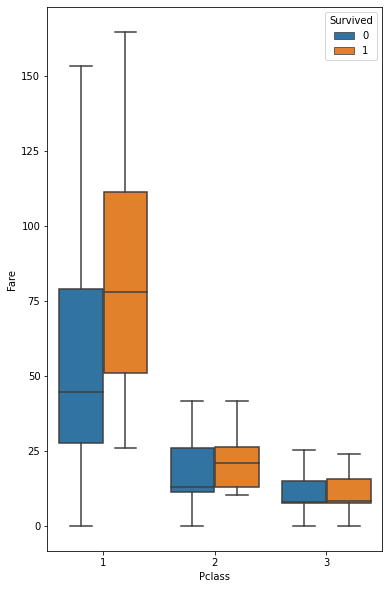

In [8]:
plt.figure(figsize=(6, 10))
sns.boxplot(data=train, x='Pclass', y='Fare', hue='Survived', showfliers=False)
plt.show()

However it turns out that ticket prices were actually shared by families or groups (unless the passenger traveled alone), and may include discount for children or additional cost (like railway fare). Some even had free tickets (price = 0). Right now we will only scale it:

In [9]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

scaled = train[['Fare']].copy()
scaled = pd.DataFrame(scaler.fit_transform(scaled), columns=scaled.columns)
train.Fare = scaled.Fare

scaled = test[['Fare']].copy()
scaled = pd.DataFrame(scaler.transform(scaled), columns=scaled.columns)
test.Fare = test.Fare

train.Fare.describe()

count    891.000000
mean       0.768745
std        2.152200
min       -0.626005
25%       -0.283409
50%        0.000000
75%        0.716591
max       21.562738
Name: Fare, dtype: float64

Next we extract ```Title``` from ```Name```, which is the second word in the string (except *the*):

In [10]:
f = lambda x: x.split(',')[1].replace('the', '').split()[0]

train['Title'] = train.Name.apply(f)
test['Title'] = test.Name.apply(f)

train.Title.value_counts()

Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Mlle.          2
Major.         2
Col.           2
Countess.      1
Capt.          1
Ms.            1
Sir.           1
Lady.          1
Mme.           1
Don.           1
Jonkheer.      1
Name: Title, dtype: int64

Drop the ```Name``` column:

In [11]:
train = train.drop(['Name'], axis=1)
test = test.drop(['Name'], axis=1)

Simplify ```Title``` category:

In [12]:
def set_title(x):
    title = x.Title.replace('.', '')
    sex = x.Sex
    if title in ['Sir', 'Jonkheer', 'Countess', 'Lady']:
        return 'Royalty'
    elif title in ['Capt', 'Col', 'Major', 'Don', 'Rev']:
        return 'Mr'
    elif title in ['Mlle', 'Mme', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if sex == 'male':
            return 'Mr'
        else:
            return 'Mrs'
    elif title in ['Master', 'Mr', 'Mrs', 'Miss']:
        return title
    else:
        return 'Other'

train.Title = train.apply(set_title, axis=1)
test.Title = test.apply(set_title, axis=1)

train.Title.value_counts()

Mr         535
Miss       186
Mrs        126
Master      40
Royalty      4
Name: Title, dtype: int64

*Master* refers to male children and *Miss* refers to (mostly younger) unmarried women. We can see that royalty, women and male children were more likely to survive.

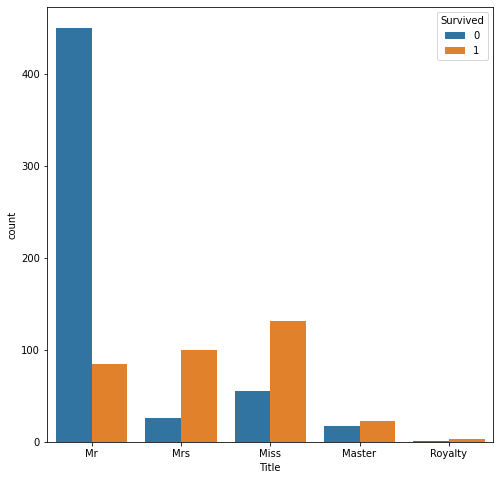

In [13]:
plt.figure(figsize=(8, 8))
sns.countplot(data=train, x='Title', hue='Survived')
plt.show()

Add a feature ```Mr``` (for these passengers were more likely to die):

In [14]:
f = lambda t: t == 'Mr'

train['Mr'] = train.Title.apply(f)
test['Mr'] = test.Title.apply(f)

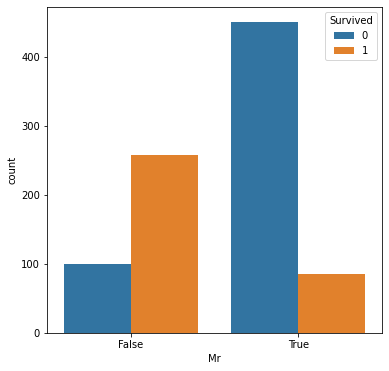

In [15]:
plt.figure(figsize=(6, 6))
sns.countplot(data=train, x='Mr', hue='Survived')
plt.show()

Now we'll look into the missing age. ```Title``` can be a useful reference:

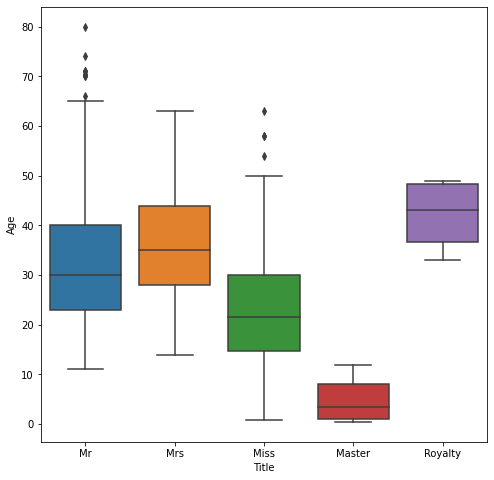

In [16]:
plt.figure(figsize=(8, 8))
sns.boxplot(data=train, x='Title', y='Age')
plt.show()

And the missing age are also mostly in the 3rd class:

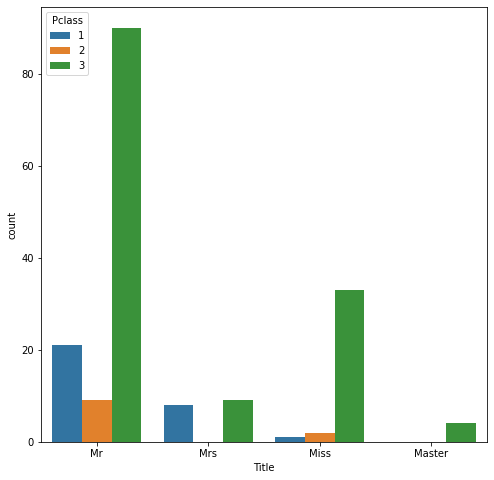

In [17]:
plt.figure(figsize=(8, 8))
sns.countplot(data=train[train.Age.isna()], x='Title', hue='Pclass')
plt.show()

Before imputing missing age data, we need to encode some categorical columns including ```Title```. First we extract ```Deck``` number from ```Cabin``` (the first letter):

In [18]:
train['Deck'] = train.Cabin.str[0]
test['Deck'] = test.Cabin.str[0]

Drop ```Cabin```:

In [19]:
train = train.drop(['Cabin'], axis=1)
test = test.drop(['Cabin'], axis=1)

```Deck``` is closely related to ```Pclass```:

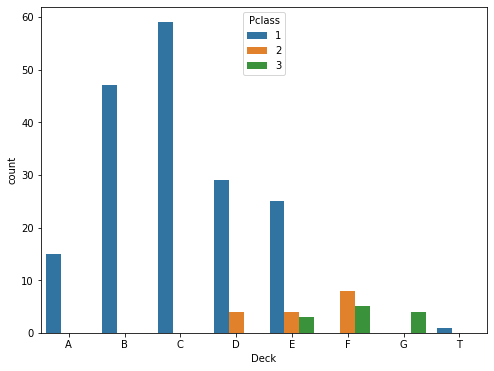

In [20]:
plt.figure(figsize=(8, 6))
sns.countplot(data=train, x='Deck', hue='Pclass', order=train.Deck.value_counts().index.sort_values())
plt.show()

```Embarked``` is also related to ```Pclass```, so we fill its NaN value with the most common port in each ticket class:

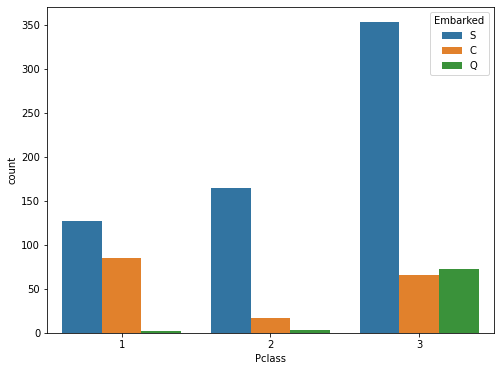

In [21]:
plt.figure(figsize=(8, 6))
sns.countplot(data=train, x='Pclass', hue='Embarked')
plt.show()

In [22]:
for c in (1, 2, 3):
    mode = train[train.Pclass==c].Embarked.mode()[0]
    train.loc[(train.Pclass==c) & (train.Embarked.isna()), 'Embarked'] = mode
    test.loc[(test.Pclass==c) & (test.Embarked.isna()), 'Embarked'] = mode

Encode ```Sex```, ```Deck``` and ```Embarked```: (the labels are the same in both datasets)

In [23]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
encode_cols = ['Sex', 'Deck', 'Embarked']

for col in encode_cols:
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])
    print('Encoding:', col, le.classes_)

Encoding: Sex ['female' 'male']
Encoding: Deck ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'T' nan]
Encoding: Embarked ['C' 'Q' 'S']


Encode ```Title``` (using *defaultdict* so unknown title in the test data will be encoded as max label + 1)):

> In fact, there is a title *Dona* (= *Mrs*) in the test dataset, but we will not process this information.

In [24]:
from collections import defaultdict

le.fit(train.Title)
le_dict = defaultdict(lambda: None, dict(zip(le.classes_, le.transform(le.classes_))))

train.Title = train.Title.map(le_dict).fillna(len(le.classes_))
test.Title = test.Title.map(le_dict).fillna(len(le.classes_))

Now take a look at ```Ticket```. Some passengers (probably families or the same groups) share tickets together:

In [25]:
train.Ticket.value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

Hence we add ```Ticket_count``` (number of shared Tickets) in both datasets, use infomation from the training set only:

In [26]:
ticket_counts = defaultdict(lambda: None, train.Ticket.value_counts().to_dict())

train['Ticket_count'] = train.Ticket.map(ticket_counts, na_action='ignore').fillna(1) - 1
test['Ticket_count'] = test.Ticket.map(ticket_counts, na_action='ignore').fillna(1) - 1

train.Ticket_count.value_counts()

0    547
1    188
2     63
3     44
6     21
5     18
4     10
Name: Ticket_count, dtype: int64

It seems that people sharing ticket with 1~3 other people were more likely to survive:

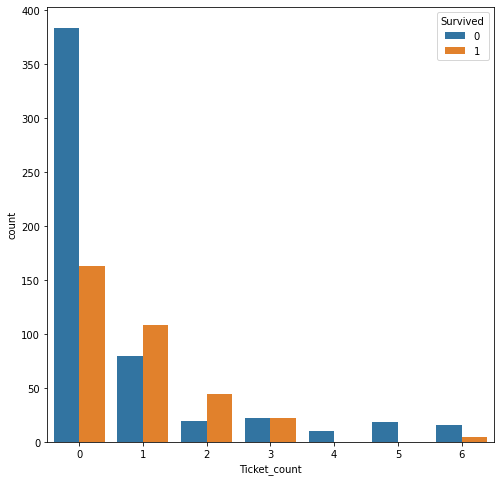

In [27]:
plt.figure(figsize=(8, 8))
sns.countplot(data=train, x='Ticket_count', hue='Survived')
plt.show()

So we add a new feature ```Small_group```:

In [28]:
f = lambda n: 1 <= n <= 3

train['Small_group'] = train.Ticket_count.apply(f)
test['Small_group'] = test.Ticket_count.apply(f)

Drop ```Ticket``` and ```Ticket_count```:

In [29]:
train = train.drop(['Ticket', 'Ticket_count'], axis=1)
test = test.drop(['Ticket', 'Ticket_count'], axis=1)

Now we use some columns to impute missing age data using KNN (k-Nearest Neighbors):

In [30]:
from sklearn.impute import KNNImputer

age_compare = train.copy()[['Age']]
cols = ['Pclass', 'Sex', 'Age', 'Title']
imputer = KNNImputer(n_neighbors=10)

imputed = train[cols].copy()
imputed = pd.DataFrame(imputer.fit_transform(imputed), columns=imputed.columns)
train.Age = imputed.Age
age_compare['Imputed_age'] = imputed.Age

imputed = test[cols].copy()
imputed = pd.DataFrame(imputer.transform(imputed), columns=imputed.columns)
test.Age = imputed.Age

train.Age.describe()

count    891.000000
mean      29.540314
std       13.251220
min        0.420000
25%       21.550000
50%       30.000000
75%       36.000000
max       80.000000
Name: Age, dtype: float64

Compare ```Age``` with the original data:

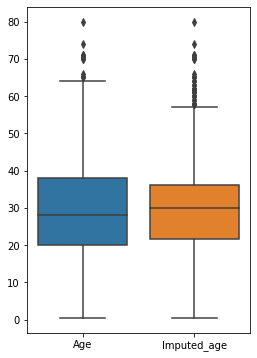

In [31]:
plt.figure(figsize=(4, 6))
sns.boxplot(data=age_compare)
plt.show()

It seems most of the imputed age data are added to the early 20s and 30s (women and men in 3rd class):

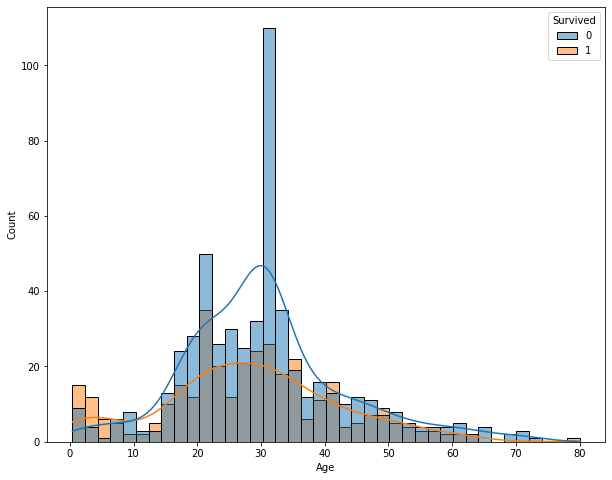

In [32]:
plt.figure(figsize=(10, 8))
sns.histplot(data=train, x='Age', bins=40, hue='Survived', kde=True)
plt.show()

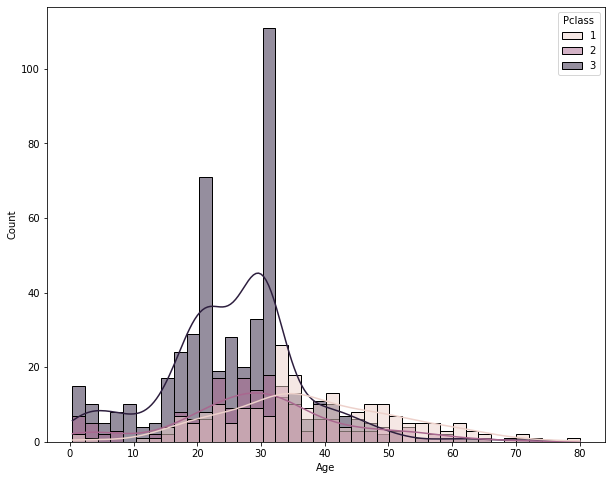

In [33]:
plt.figure(figsize=(10, 8))
sns.histplot(data=train, x='Age', bins=40, hue='Pclass', kde=True)
plt.show()

And it looks like children age 8 or under are most likely to survive:

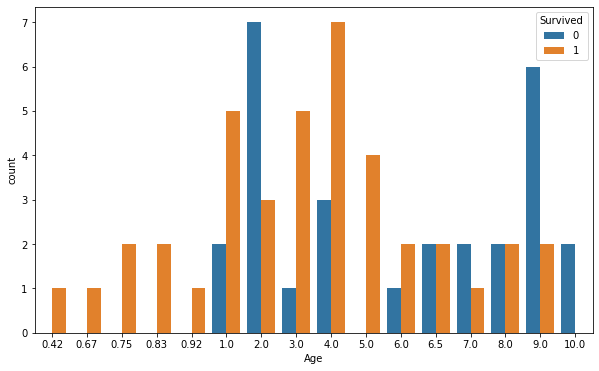

In [34]:
plt.figure(figsize=(10, 6))
sns.countplot(data=train[train.Age <= 10], x='Age', hue='Survived')
plt.show()

Add a new feature ```Child```:

In [35]:
f = lambda n: n <= 8

train['Child'] = train.Age.apply(f)
test['Child'] = test.Age.apply(f)

Scale ```Age```:

In [36]:
scaler = RobustScaler()

scaled = train[['Age']].copy()
scaled = pd.DataFrame(scaler.fit_transform(scaled), columns=scaled.columns)
train.Age = scaled.Age

scaled = test[['Age']].copy()
scaled = pd.DataFrame(scaler.transform(scaled), columns=scaled.columns)
test.Age = test.Age

train.Age.describe()

count    891.000000
mean      -0.031812
std        0.917039
min       -2.047059
25%       -0.584775
50%        0.000000
75%        0.415225
max        3.460208
Name: Age, dtype: float64

Now add a new feature ```Family``` (```SibSp``` + ```Parch```):

In [37]:
train['Family'] = train.SibSp + train.Parch
test['Family'] = test.SibSp + test.Parch

It seems people traveling with a family size of 1~3 were more likely to survive:

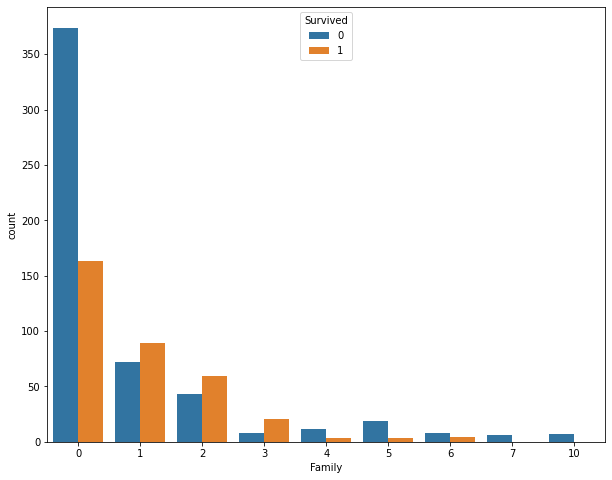

In [38]:
plt.figure(figsize=(10, 8))
sns.countplot(data=train, x='Family', hue='Survived')
plt.show()

So add a new feature ```Small_family```:

In [39]:
f = lambda n: 1 <= n <= 3

train['Small_family'] = train.Family.apply(f)
test['Small_family'] = test.Family.apply(f)

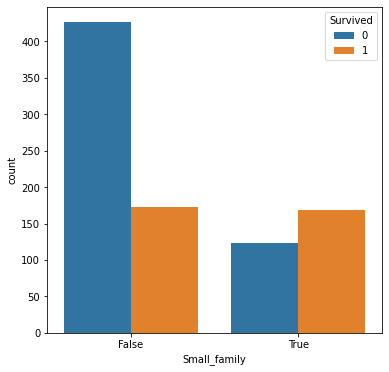

In [40]:
plt.figure(figsize=(6, 6))
sns.countplot(data=train, x='Small_family', hue='Survived')
plt.show()

Now drop ```PassengerId```:

In [41]:
train.pop('PassengerId')
passenger_id = test.pop('PassengerId')

After all above are done, inspect the correlation between each features and ```Survived```:

In [42]:
train.corr().Survived

Survived        1.000000
Pclass         -0.338481
Sex            -0.543351
Age            -0.076057
SibSp          -0.035322
Parch           0.081629
Fare            0.257307
Embarked       -0.167675
3rd_class      -0.322308
Title          -0.064717
Mr             -0.567068
Deck           -0.301116
Small_group     0.298000
Child           0.147223
Family          0.016639
Small_family    0.279855
Name: Survived, dtype: float64

Drop columns that have low correlations (< 0.1) to ```Survived```:

In [43]:
drop_cols = []

for col, corr in zip(train.corr().Survived.index, train.corr().Survived):
    if abs(corr) < 0.1:
        drop_cols.append(col)

print('Dropping cols:', drop_cols)

train = train.drop(drop_cols, axis=1)
test = test.drop(drop_cols, axis=1)

Dropping cols: ['Age', 'SibSp', 'Parch', 'Title', 'Family']


Ttake a look at correlations between all features:

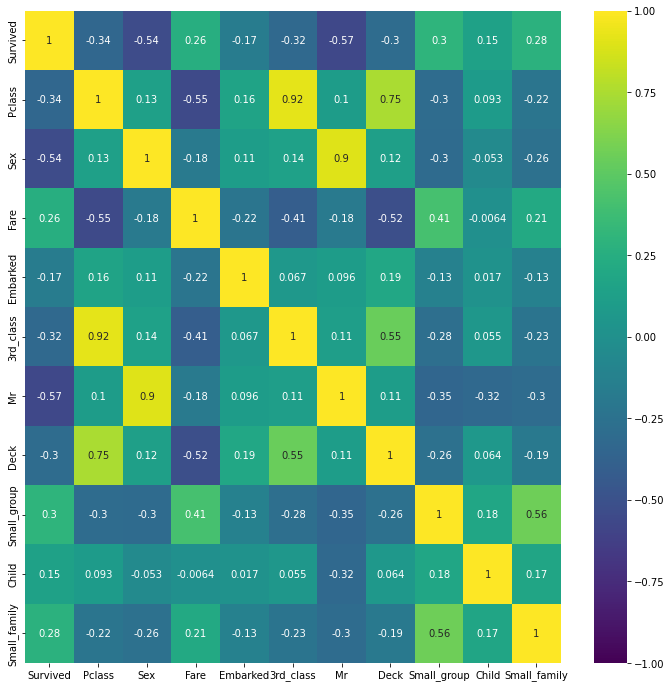

In [44]:
plt.figure(figsize=(12, 12))
sns.heatmap(data=train.corr(), annot=True, vmin=-1, vmax=1, cmap='viridis')
plt.show()

Drop the columns that are highly correlated with others:

> Note that ```3rd_class``` has slightly lower correlation with ```Survived``` compared to ```Pclass```, but ```Pclass``` has high correlation with ```Deck``` (collinearity). So we drop ```Pclass``` instead of ```3rd_class``` and ```Deck```.

In [45]:
drop_cols = ['Pclass', 'Sex']

train = train.drop(drop_cols, axis=1)
test = test.drop(drop_cols, axis=1)

And these are our final features for model training:

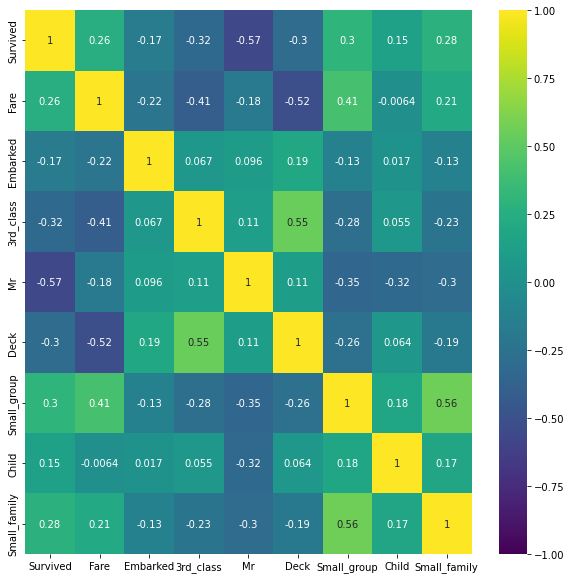

In [46]:
plt.figure(figsize=(10, 10))
sns.heatmap(data=train.corr(), annot=True, vmin=-1, vmax=1, cmap='viridis')
plt.show()

### Train FLAML model

In [47]:
from flaml import AutoML

clf = AutoML()
clf.fit(dataframe=train, label='Survived', 
        task='classification', 
        estimator_list=['lgbm', 'xgboost'],
        metric='ap',
        time_budget=3600)

[flaml.automl: 01-31 23:21:33] {2051} INFO - task = classification
[flaml.automl: 01-31 23:21:33] {2053} INFO - Data split method: stratified
[flaml.automl: 01-31 23:21:33] {2057} INFO - Evaluation method: cv
[flaml.automl: 01-31 23:21:33] {2138} INFO - Minimizing error metric: 1-ap
[flaml.automl: 01-31 23:21:33] {2196} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost']
[flaml.automl: 01-31 23:21:33] {2449} INFO - iteration 0, current learner lgbm
[flaml.automl: 01-31 23:21:33] {2562} INFO - Estimated sufficient time budget=783s. Estimated necessary time budget=1s.
[flaml.automl: 01-31 23:21:33] {2609} INFO -  at 0.1s,	estimator lgbm's best error=0.1974,	best estimator lgbm's best error=0.1974
[flaml.automl: 01-31 23:21:33] {2449} INFO - iteration 1, current learner lgbm
[flaml.automl: 01-31 23:21:33] {2609} INFO -  at 0.2s,	estimator lgbm's best error=0.1769,	best estimator lgbm's best error=0.1769
[flaml.automl: 01-31 23:21:33] {2449} INFO - iteration 2, current learner lg

In [51]:
print('Best ML leaner:', clf.best_estimator)
print('Best hyperparmeter config:\n', clf.best_config)

Best ML leaner: xgboost
Best hyperparmeter config:
 {'n_estimators': 83, 'max_leaves': 182, 'min_child_weight': 0.09664112300387367, 'learning_rate': 0.01964775601689325, 'subsample': 0.3307000633225146, 'colsample_bylevel': 1.0, 'colsample_bytree': 0.6412403618988516, 'reg_alpha': 0.24054002560925436, 'reg_lambda': 0.018369643406268486}


In [52]:
predicted = clf.predict(train.drop(['Survived'], axis=1)).astype('uint8')

In [53]:
from sklearn.metrics import accuracy_score

print('Train dataset accuracy:', accuracy_score(train.Survived, predicted).round(5))

Train dataset accuracy: 0.89226


### Predict test labels and generate submission

In [54]:
predicted = clf.predict(test).astype('uint8')

In [55]:
submission = pd.DataFrame({'PassengerId': passenger_id, 'Survived': predicted})
submission.to_csv('./submission.csv', index=False)

submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


Kaggle score (categorical accuracy): **0.78708**